In [2]:
import requests as re
from bs4 import BeautifulSoup as bs
import pandas as pd

fecha = '2025-03-03'
url = f'https://www.avamet.org/mx-meteoxarxa.php?id={fecha}&territori=p46'
url_main = 'https://www.avamet.org/'

response = re.get(url)
if response.status_code == 200:
    soup = bs(response.text, 'html.parser')

tabla = soup.find('table', class_='tDades')
filas = tabla.find_all('tr')
datos = []

for fila in filas:

    try:
        dic = {}
        elementos = fila.find_all('td')
        if len(elementos) > 4:
            zona = elementos[0].find('a').text
            dic['Zona'] = zona
            print(zona)
            link = elementos[0].find('a')['href']
            
            response2 = re.get(url_main + link)
            if response2.status_code == 200:
                soup2 = bs(response2.text, 'html.parser')
                tabla2 = soup2.find('table', class_='fitxa')
                valores = tabla2.find_all('tr')

                dic['Municipio'] = valores[2].find('td',class_='fitxaValN').text
                dic['Ubicación'] = valores[4].find(class_='fitxaValN').text
                dic['Comarca'] = valores[5].find(class_='fitxaVal').text
                dic['Provincia'] = valores[6].find(class_='fitxaVal').text
                dic['Coordenadas'] = valores[7].find(class_='fitxaValN').text
                dic['Altitud'] = valores[8].find(class_='fitxaValN').text

                datos.append(dic)
    except:
        pass

df = pd.DataFrame(datos)
    

 AdemuzIES Ademuz
 AdemuzAEMET
 Casas Bajas
 Castielfabib
 CastielfabibArroyo Cerezo
 Puebla de San Miguel
 Alpuente
 AlpuenteLa Torre
 Aras de los Olmos
 CallesAlcotas
 CallesParque de Emergencias
 Chelva
 ChelvaAEMET
 ChulillaVanacloig 
 Pedralba Balsa de la Serratella 
 Pedralba Cueva del Terrero 
 Sot de Chera
 TitaguasCosmofísica
 Villar del Arzobispo
 Villar del ArzobispoCasica Roger
 BenaguasilEstil Masculí Eva
 Benaguasileste
 BéteraMas de Juan Luís 
 Béterala Conarda
 Bétera
 BéteraUrb. Mas Camarena
 Casinos
 l′Elianacentre
 l′ElianaBarranc de Mandor
 l′Elianapoble
 l′ElianaPinaeta del Cel
 LlíriaBasseta del Vaquer 
 Llíria
 LoriguillaPozalet
 Marines
 NàqueraGermanells
 Nàquera
 Olocau
 la Pobla de Vallbona
 la Pobla de VallbonaRincons
 la Pobla de VallbonaGallipont
 Riba-roja de TúriaIES el Quint
 Riba-roja de Túriala Reva
 Riba-roja de Túria
 Serra
 VilamarxantSan José
 VilamarxantLa Pedrera
 VilamarxantAyuntamiento
 VilamarxantMas de Teulada
 Gátova
 San Antonio de Benagéb

In [3]:
def get_coords(cord):

    c = cord.split(',')[0].split(' ')
    c[0] = float(c[0][:-1])
    c[1] = float(c[1][:-1])
    c[2] = float(c[2][:-1])
    c = c[:-1]
    lat = c[0] + c[1]/60 + c[2]/3600

    c = cord.split(',')[1].split(' ')[1:]
    c[0] = float(c[0][:-1])
    c[1] = float(c[1][:-1])
    c[2] = float(c[2][:-1])
    c = c[:-1]
    long = -1* (c[0] + c[1]/60 + c[2]/3600)

    return lat, long

def get_altitud(val):
    try:
        v = int(val[:-2])
    except:
        v = None
    
    return v

df[['Latitud', 'Longitud']] = df['Coordenadas'].apply(lambda x: pd.Series(get_coords(x)))
df['Altitud'] = df['Altitud'].apply(get_altitud)

In [4]:
df = df.drop('Coordenadas', axis=1)
df = df.drop('Ubicación', axis=1)
df.head()

,Zona,Municipio,Comarca,Provincia,Altitud,Latitud,Longitud
0,AdemuzIES Ademuz,Ademuz,El Rincón de Ademuz,València,710.0,40.059978,-1.285122
1,AdemuzAEMET,Ademuz,El Rincón de Ademuz,València,710.0,40.059100,-1.282200
2,Casas Bajas,Casas Bajas,El Rincón de Ademuz,València,685.0,40.020639,-1.260397
3,Castielfabib,Castielfabib,El Rincón de Ademuz,València,950.0,40.131133,-1.304150
4,CastielfabibArroyo Cerezo,Castielfabib,El Rincón de Ademuz,València,1312.0,40.121364,-1.420292


In [5]:
df2 = pd.read_csv('/Users/pablogandia/Downloads/estaciones_valencia_final.csv',index_col=0)
df2.head()

,Estación,Latitud,Longitud,Altitud
Municipio,,,,
Alberic,Alberic UM,39.116667,-0.518056,26.0
Alberic,Alberic UM2,39.123749,-0.563459,78.0
Algar de Palància,Algar de Palància,39.782307,-0.359213,195.0
Cortes de Pallás,Cortes de Pallás,39.260898,-0.934642,500.0
Sagunt,Sagunt - CEA,39.633036,-0.266684,9.0


In [6]:
from geopy.distance import geodesic

def municipio_mas_cercano(row):
    estacion_coords = (row['Latitud'], row['Longitud'])
    df['Distancia'] = df.apply(lambda x: geodesic(estacion_coords, (x['Latitud'], x['Longitud'])).km, axis=1)
    m = df.loc[df['Distancia'].idxmin(), 'Zona']
    lat = df.loc[df['Distancia'].idxmin(), 'Latitud']
    lon = df.loc[df['Distancia'].idxmin(), 'Longitud']
    alt = df.loc[df['Distancia'].idxmin(), 'Altitud']
    return m,lat,lon,alt

df2[['Controlador', 'C_Latitud', 'C_Longitud', 'C_Altitud']] = df2.apply(municipio_mas_cercano, axis=1, result_type='expand')

df2.head()

,Estación,Latitud,Longitud,Altitud,Controlador,C_Latitud,C_Longitud,C_Altitud
Municipio,,,,,,,,
Alberic,Alberic UM,39.116667,-0.518056,26.0,Massalavés,39.140647,-0.521017,36.0
Alberic,Alberic UM2,39.123749,-0.563459,78.0,Gavardala Travessa,39.093772,-0.555789,32.0
Algar de Palància,Algar de Palància,39.782307,-0.359213,195.0,Algar de Palància,39.781494,-0.367767,188.0
Cortes de Pallás,Cortes de Pallás,39.260898,-0.934642,500.0,Cortes de PallásVenta de Gaeta,39.307525,-0.960000,665.0
Sagunt,Sagunt - CEA,39.633036,-0.266684,9.0,Sagunt les Lloses,39.647506,-0.293922,0.0


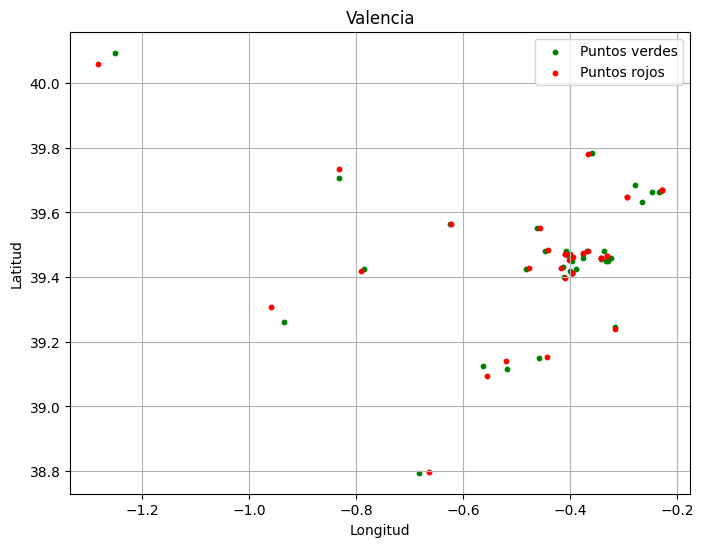

In [7]:
import matplotlib.pyplot as plt

latitudes_verde = df2['Latitud']
longitudes_verde = df2['Longitud']

latitudes_rojo = df2['C_Latitud']
longitudes_rojo = df2['C_Longitud']

plt.figure(figsize=(8, 6))
plt.scatter(longitudes_verde, latitudes_verde, color='green', label='Puntos verdes', s=10)
plt.scatter(longitudes_rojo, latitudes_rojo, color='red', label='Puntos rojos', s=10)

plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.title("Valencia")
plt.legend()
plt.grid(True)

plt.show()


In [7]:
d1 = pd.read_csv('/Users/pablogandia/Desktop/Analisis_aire/data/raw/geoespacial/estaciones_valencia.csv')
print(len(d1))
print(len(df2))

27
36


In [9]:
import pandas as pd
from bs4 import BeautifulSoup as bs
import requests as re
import datetime

zonas = list(df2['Controlador'].unique())
print(zonas)

[' Massalavés', ' Gavardala Travessa', ' Algar de Palància', ' Cortes de PallásVenta de Gaeta', ' Sagunt les Lloses ', ' SaguntPuerto de Sagunto', ' MassanassaIES Massanassa', ' SuecaMuntanyeta dels Sants', ' AdemuzAEMET', ' TorrentAv. al Vedat', ' ValènciaIES Districte Marítim', ' ValènciaSant Isidre', ' ValènciaMicalet', ' ValènciaColegio Pureza de María-Cid', ' ValènciaPatraix', ' ValènciaColegio Pureza de María-Grao', ' ValènciaViveros AEMET', " Valèncial'Olivereta", ' VilamarxantSan José', ' Villar del Arzobispo', ' AlziraAjuntament', ' Buñol', ' Albalcentro', ' OntinyentManuel Iranzo ', ' Paiporta', ' BéteraUrb. Mas Camarena', ' Quart de Poblet']


In [10]:
def filt_zonas(url,zonas):
    resultado = []
    response = re.get(url)
    if response.status_code == 200:
        soup = bs(response.text, 'html.parser')
        tabla = soup.find('table', class_='tDades')
        filas = tabla.find_all('tr')
        for fila in filas:
            try:
                elementos = fila.find_all('td')
                if len(elementos) > 4:
                    zona = elementos[0].find('a').text
                    if zona in zonas:
                        resultado.append(fila)
            except:
                pass
    return resultado

def get_datos(fila,fecha):
    dic = {}
    elementos = fila.find_all('td')
    dic['Zona'] = elementos[0].find('a').text
    dic['Fecha'] = fecha
    dic['T_min'] = elementos[1].text
    dic['T_mit'] = elementos[2].text
    dic['T_max'] = elementos[3].text
    dic['HR'] = elementos[4].text
    dic['Precip'] = elementos[5].text
    dic['V_mit'] = elementos[6].text
    dic['V_dir'] = elementos[7].text
    dic['V_max'] = elementos[8].text
    return dic



In [11]:
start_date = datetime.date(2004, 1, 1)
end_date = datetime.date.today()
delta = datetime.timedelta(days=1)

date_range = [end_date - datetime.timedelta(days=x) for x in range((end_date - start_date).days + 1)]
cont = 0
datos = []

for current_date in date_range:
    cont += 1
    fecha = current_date.strftime('%Y-%m-%d')
    url = f'https://www.avamet.org/mx-meteoxarxa.php?id={fecha}&territori=p46'

    if cont % 50 == 0:
        print(fecha)

    try:
        filas = filt_zonas(url,zonas)
        if len(filas) > 0:
            for fila in filas:
                try:
                    datos.append(get_datos(fila,fecha))
                except:
                    pass
    except:
        print('Error')

df = pd.DataFrame(datos)
df.to_csv('/Users/pablogandia/Desktop/temperaturas_diarias.csv')

2025-02-27
2025-01-08
2024-11-19
2024-09-30
2024-08-11
2024-06-22
2024-05-03
2024-03-14
2024-01-24
2023-12-05
2023-10-16
2023-08-27
2023-07-08
2023-05-19
2023-03-30
2023-02-08
2022-12-20
2022-10-31
2022-09-11
2022-07-23
2022-06-03
2022-04-14
2022-02-23
2022-01-04
2021-11-15
2021-09-26
2021-08-07
2021-06-18
2021-04-29
2021-03-10
2021-01-19
2020-11-30
2020-10-11
2020-08-22
2020-07-03
2020-05-14
2020-03-25
2020-02-04
2019-12-16
2019-10-27
2019-09-07
2019-07-19
2019-05-30
2019-04-10
2019-02-19
2018-12-31
2018-11-11
2018-09-22
2018-08-03
2018-06-14
2018-04-25
2018-03-06
2018-01-15
2017-11-26
2017-10-07
2017-08-18
2017-06-29
2017-05-10
2017-03-21
2017-01-30
2016-12-11
2016-10-22
2016-09-02
2016-07-14
2016-05-25
2016-04-05
2016-02-15
2015-12-27
2015-11-07
2015-09-18
2015-07-30
2015-06-10
2015-04-21
2015-03-02
2015-01-11
2014-11-22
2014-10-03
2014-08-14
2014-06-25
2014-05-06
2014-03-17
2014-01-26
2013-12-07
2013-10-18
2013-08-29
2013-07-10
2013-05-21
2013-04-01
2013-02-10
2012-12-22
2012-11-02

In [8]:
df2.to_csv('/Users/pablogandia/Desktop/estaciones_valencia.csv',index=False)